# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model. You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
import scipy.stats as st
import seaborn as sns
sns.set_style('darkgrid')

The $GARCH(1,1)$ model has the following form: $\sigma^2_t = \omega + \alpha r^2_{t-1} + \beta\sigma^2_{t-1}$ where $\omega$ is a kind of baseline variance and $r_{t-1}$ is yesterday's return. The constants $\alpha,\beta$ are weights for how much yesterday's returns and volatility impact today's volatility.

In this miniproject, I'll try using GARCH to model nonconstant volatility (we need to fit to some historic data) and then using that, implement a delta hedging strategy.

In [ ]:
def fetch_returns(ticker, period="5y"):
    df = yf.download(ticker, period=period, progress=False)
    df['LogRet'] = np.log(df['Close']).diff().dropna()
    df=df.dropna()
    return df['LogRet'], float(df['Close'].values[-1][0])

def fit_garch(returns):
    # Fit GARCH(1,1) to returns (in percent)
    am = arch_model(returns * 100, vol='Garch', p=1, q=1, dist='normal')
    res = am.fit(disp='off')
    params = res.params
    return params['omega'], params['alpha[1]'], params['beta[1]']

# using the GARCH(1,1) model, we'll simulate a bunch of paths
def simulate_garch_paths(S0, mu, omega, alpha, beta, T, N, n_paths):
    dt = T / N
    prices = np.zeros((n_paths, N+1))
    sig2 = np.zeros_like(prices)
    prices[:, 0] = S0
    # Initialize variance at unconditional level
    sig2[:, 0] = omega / (1 - alpha - beta)
    
    for t in range(1, N+1):
        eps = np.random.normal(size=n_paths)
        sig2[:, t] = omega + alpha * (eps**2 * sig2[:, t-1]) + beta * sig2[:, t-1]
        sigma = np.sqrt(sig2[:, t]) / 100  # back to fraction
        prices[:, t] = prices[:, t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma*np.sqrt(dt)*eps)
    
    return prices, np.sqrt(sig2) / 100

# function to compute delta
def bs_delta(S, K, t, T, r, sigma):
    tau = T - t
    sq = np.sqrt(tau)
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * sq)
    d2 = d1 - sigma * sq
    price = S * st.norm.cdf(d1) - K * np.exp(-r*tau) * st.norm.cdf(d2)
    delta = st.norm.cdf(d1)
    return price, delta

# delta hedging strategy that uses the nonconstant sigmas
# for this delta hedge, we're able to pass in lots of different GARCH paths.
# So if we have 100 GARCH paths, what it returns is the money we would make with delta hedging on those 100 paths
def run_delta_hedge(prices, sigmas, K, T, r):
    n_paths, steps = prices.shape
    dt = T / (steps - 1)
    rebalance_times = np.linspace(0, T, steps)
    pnl = np.zeros(n_paths)
    
    for i in range(n_paths):
        cash = 0.0
        # initial delta
        p0, d0 = bs_delta(prices[i,0], K, 0, T, r, sigmas[i,0])
        shares = -d0
        cash += p0 + d0 * prices[i,0]
        
        for t_idx in range(1, steps):
            t = rebalance_times[t_idx]
            # earn interest
            cash *= np.exp(r * dt)
            # trade the shares we have at current price
            cash -= shares * prices[i, t_idx]
            # new delta, get some shares, find their value
            _, d_new = bs_delta(prices[i,t_idx], K, t, T, r, sigmas[i,t_idx])
            shares = -d_new
            cash += d_new * prices[i, t_idx]
        
        # last step at maturity
        cash *= np.exp(r * dt)
        cash -= shares * prices[i, -1]
        cash -= bs_delta(prices[i, -1], K, T, T, r, sigmas[i, -1])[0]
        pnl[i] = cash
    
    return pnl

/var/folders/_d/c5j2kkcx3jvfgg9tymcv58yr0000gn/T/ipykernel_12137/4189121115.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * sq)


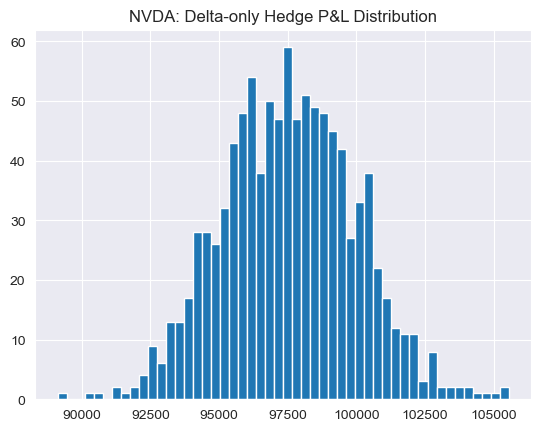

/var/folders/_d/c5j2kkcx3jvfgg9tymcv58yr0000gn/T/ipykernel_12137/4189121115.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * sq)


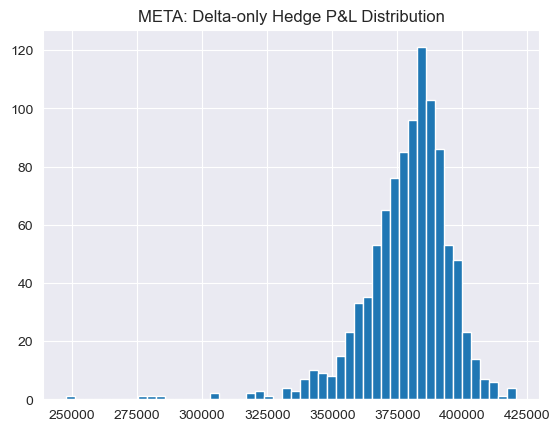

/var/folders/_d/c5j2kkcx3jvfgg9tymcv58yr0000gn/T/ipykernel_12137/4189121115.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * sq)


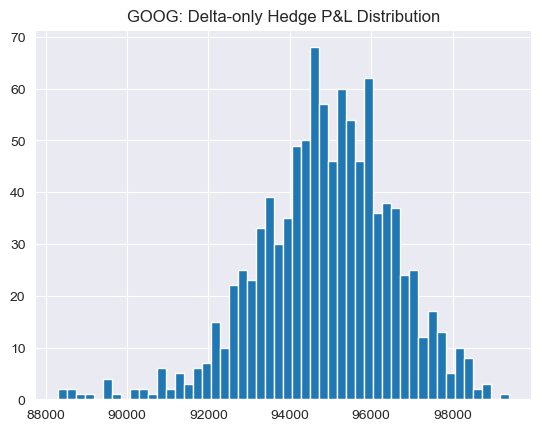

/var/folders/_d/c5j2kkcx3jvfgg9tymcv58yr0000gn/T/ipykernel_12137/4189121115.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * sq)


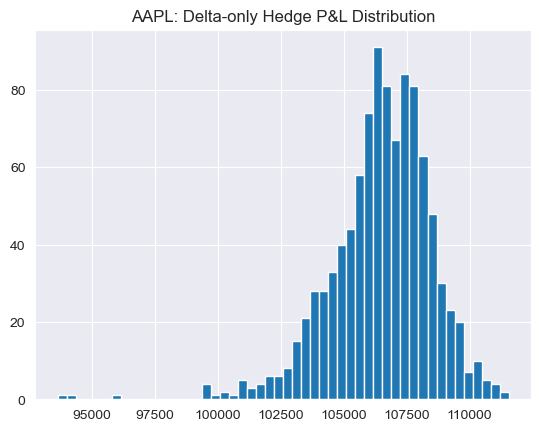

/var/folders/_d/c5j2kkcx3jvfgg9tymcv58yr0000gn/T/ipykernel_12137/4189121115.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * sq)


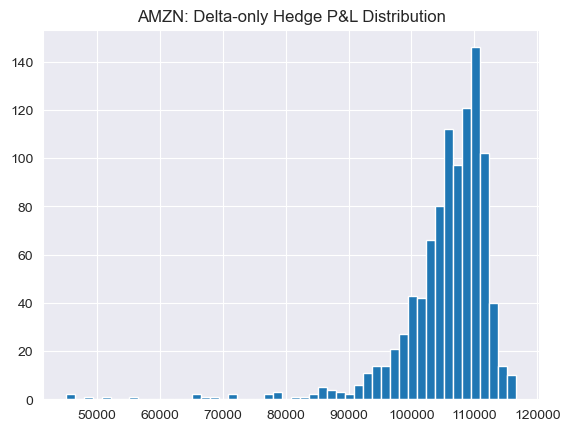

In [ ]:
# try on some tech stocks, 5 year periods
tickers = ['NVDA', 'META', 'GOOG', 'AAPL', 'AMZN']
for ticker in tickers:
    returns, S0 = fetch_returns(ticker)
    mu = returns.mean() * 252
    omega, alpha, beta = fit_garch(returns)

    # simulation parameters
    T = 1.0
    N = 252
    n_paths = 1000
    r = 0.01
    K = S0  # at the money strike
    prices, sigmas = simulate_garch_paths(S0, mu, omega, alpha, beta, T, N, n_paths)

    # run delta hedge
    pnl_delta = run_delta_hedge(prices, sigmas, K, T,r)

    # plot results
    plt.figure()
    plt.hist(pnl_delta, bins=50)
    plt.title(f"{ticker}: Delta-only Hedge P&L Distribution")

    plt.show()


Remember, with $T=1$, that means we're working with options that expire in a full year and we have lots of opportunities to trade. Also, options usually control 100 shares. So the profits and loss could potentially be large numbers.

Below are cells that Thomas wrote.

In [2]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

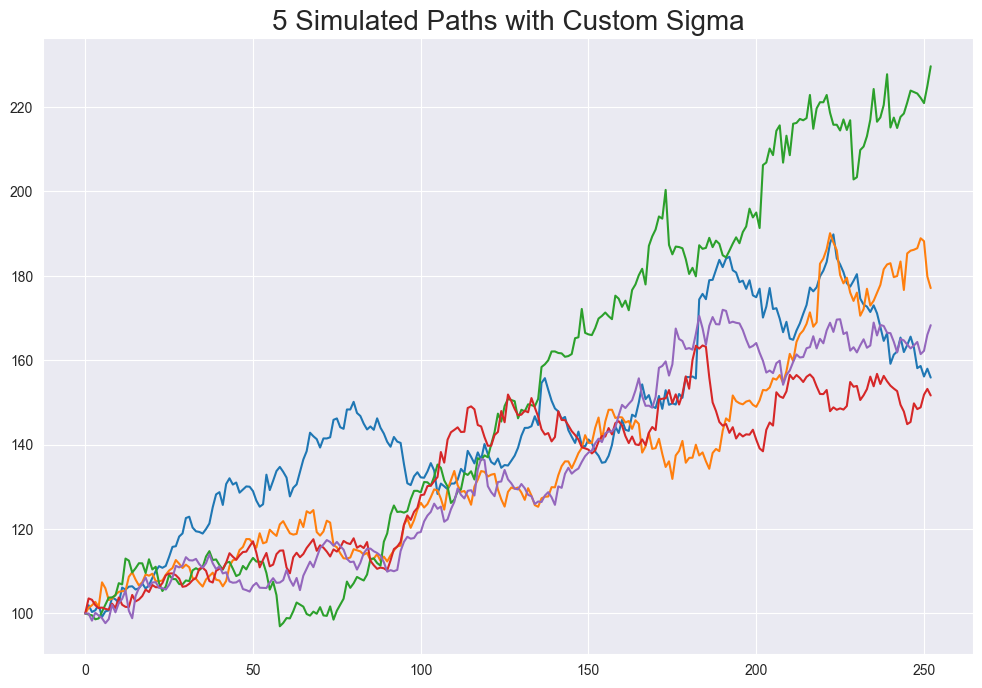

In [7]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()